# Finding surveillance planes using random forests

**The story:**

- https://www.buzzfeednews.com/article/peteraldhous/spies-in-the-skies
- https://www.buzzfeednews.com/article/peteraldhous/hidden-spy-planes
    
This story, done by Peter Aldhous at Buzzfeed News, involved training a machine learning algorithm to recognize government surveillance planes based on what their flight patterns look like.

**Topics:** Random Forests

**Datasets**

* **feds.csv:** Transponder codes of planes operated by the federal government
* **planes_features.csv:** various features describing each plane's flight patterns
* **train.csv:** a labeled dataset of transponder codes and whether each plane is a surveillance plane or not
    - The `label` column was originally `class`, but I renamed it because pandas freaks out a bit with a column named `class`
    - This was created by Buzzfeed `feds.csv`
* **data dictionary:** You can find the data dictionary published with their analysis [here](https://buzzfeednews.github.io/2016-04-federal-surveillance-planes/analysis.html)
* **a few other files**

## What's the goal?

The FBI and Department of Homeland Security operate many planes that are not directly labeled as belonging to the government. If we can uncover these planes, we have a better idea of the surveillance activities they are undertaking.

## Imports

Also set a large number of maximum columns.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",100)

# Read in our data

Almost all classification problems start with a set of labeled features. In this case, the features are in one CSV file and the labels are in another. **Read both files in and merge them on `adshex`, the transpoder code.**

In [2]:
features=pd.read_csv("planes_features.csv")

In [3]:
features.shape

(19799, 33)

In [4]:
features.columns

Index(['adshex', 'duration1', 'duration2', 'duration3', 'duration4',
       'duration5', 'boxes1', 'boxes2', 'boxes3', 'boxes4', 'boxes5', 'speed1',
       'speed2', 'speed3', 'speed4', 'speed5', 'altitude1', 'altitude2',
       'altitude3', 'altitude4', 'altitude5', 'steer1', 'steer2', 'steer3',
       'steer4', 'steer5', 'steer6', 'steer7', 'steer8', 'flights', 'squawk_1',
       'observations', 'type'],
      dtype='object')

In [5]:
features.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7
2,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP
3,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46
4,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X


In [6]:
labels=pd.read_csv("train.csv")

In [7]:
labels.columns

Index(['adshex', 'label'], dtype='object')

In [8]:
labels.head()

,adshex,label
0,A00C4B,surveil
1,A0AB21,surveil
2,A0AE77,surveil
3,A0AE7C,surveil
4,A0C462,surveil


In [9]:
df=features.merge(labels, on="adshex", how="left")

In [10]:
df.shape

(19799, 34)

### No wait, merge them again!

We have features for about 20,000 planes and labels for about 600 planes. When you merge, the planes you have features for but not labels for will disappear.

We want to keep those in the dataframe so we can play detective with them later, and try to find surveillance planes using the features. When you merge, you should use `how='left'` or `how='right'` to keep unmatched columns from the left (or right) dataframe.

Confirm you have 19,799 rows and 34 columns.

In [11]:
#Yes

# Cleaning up our data

## Number-izing our labels

Each row is a plane, and it's marked as either a surveillance plane or not. How many do we have in each category?

In [12]:
df.label.value_counts()

other      500
surveil     97
Name: label, dtype: int64

How do you feel about that split?

**Prepare this column for machine learning.** What's wrong with it as `"surveil"` and `"other"`? Add a new column that we can use for classification.

In [13]:
df.label=df.label.replace({
    "other":0,
    "surveil":1
})

In [14]:
#Re-checking the variable to make sure it is encoded correctly
df.label.value_counts()

0.0    500
1.0     97
Name: label, dtype: int64

In [15]:
df.head()

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label
0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,NaN
1,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,NaN
2,A00002,0.517241,0.103448,0.103448,0.103448,0.172414,0.862069,0.137931,0.000000,0.000000,0.000000,0.990792,0.000921,0.000000,0.000000,0.008287,0.599448,0.400552,0.000000,0.000000,0.000000,0.105893,0.090239,0.174954,0.244015,0.034070,0.202578,0.021179,0.068140,29,0,1086,SHIP,0.0
3,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,NaN
4,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,NaN


## Categorical variables

Do we have any variables that count as categories? Yes, we do! ...but how many different categories does it have?

* **Tip:** You can use `.unique()` or `.value_counts()` to count unique items, depending on what you're looking for

In [16]:
df.type.value_counts()

unknown    2528
C172       1014
SR22        799
BE36        699
C182        693
PC12        630
BE20        465
PA46        438
P28A        415
BE9L        408
C208        395
BE58        387
M20P        335
B350        333
P46T        285
C82S        235
T206        234
C421        225
BE35        222
DA40        214
BE55        204
TBM8        204
B407        202
C340        199
COL4        196
M20T        180
C414        177
AS50        175
EA50        167
PA32        161
           ... 
BE45          1
SVNH          1
AT75          1
DHC1          1
CV64          1
VTUR          1
MIMU          1
PULS          1
L90           1
GYRO          1
TAMP          1
S108          1
EGRT          1
M20J          1
SYMP          1
ONEX          1
J2            1
B212          1
A4            1
COL           1
B427          1
B58           1
T850          1
MC90          1
E545          1
TVL4          1
DE55          1
SF50          1
TAGO          1
BE80          1
Name: type, Length: 455,

Most of those types of plane only have one appearance, which means they wouldn't be very helpful identifiers in the final analysis. For example, if I only see one GLF5 and it's a surveillance plane, does that mean the next one I see is probably a surveillance plane? With such a small sample size, I have no idea!

We have a few options

1. Create a very large set of dummy variables out of all 133 types of planes
2. Create `0`/`1` columns for common plane types and ignore the less common ones -  C182, T206, SR22
3. Interview someone who knows something about planes and put these into a few broader categories
4. Keep them as one column, just turn them into numbers - it doesn't make sense in terms of order, but if one or two plane types are very indicative of a surveillance plane the forest might pick it up

Oddly enough, **the last one is a common approach.** Let's use it!

If you want to convert a list of categories into numbers, an easy way is to use the `Categorical` data type.

In [17]:
df.type = df.type.astype('category')
df.type.head()

0    GRND
1    TBM7
2    SHIP
3    PA46
4    C56X
Name: type, dtype: category
Categories (455, object): [208, A109, A119, A139, ..., WW24, XL2, ZZZZ, unknown]

It looks like a normal bunch of strings, but pandas is secretly using a number for each one! You can find the number with `.cat.codes`.

**Use `df.type.cat.codes` to make a new columns called `type_code`.** 

In [18]:
df["type_code"]=df.type.cat.codes

In [19]:
df["type_code"].value_counts()

454    2528
88     1014
406     799
54      699
91      693
356     630
48      465
350     438
323     415
69      408
97      395
60      387
300     335
33      333
333     285
133     235
417     234
115     225
53      222
163     214
432     204
58      204
35      202
110     199
148     196
301     180
114     177
18      175
191     167
347     161
       ... 
123       1
187       1
361       1
203       1
450       1
434       1
299       1
402       1
370       1
363       1
282       1
250       1
234       1
307       1
393       1
409       1
425       1
26        1
42        1
20        1
4         1
435       1
419       1
403       1
138       1
371       1
202       1
339       1
218       1
0         1
Name: type_code, Length: 455, dtype: int64

We'll use `type_code` for machine learning since sklearn needs a number, and `type` for reading since we like text.

# Building our classifier

When we're about to classify, we usually just drop our target column to build our inputs and outputs:

```python
X = train_df.drop(column='column_you_are_predicting')
y = train_df.column_you_are_predicting
```

This time is a little different. First, we have unlabeled data in there! Use `.dropna()` to filter your training data so we only have labeled data.

Confirm `train_df` has 597 rows and 35 columns.

We also have a few extra columns that we aren't using for classification (like the text version of the type column and the transponder code). It's fine to drop multiple columns here that you aren't using, just a little bit messier. You also have to make sure you're dropping all the right ones.

Do a `.head()` to double-check all of the columns you need to drop when creating your `X`.

In [20]:
train_df=df.dropna(subset=["label"])

In [21]:
train_df.label.value_counts()

0.0    500
1.0     97
Name: label, dtype: int64

In [22]:
#Note: Non-surveillance planes are under-represented in our dataset, as a result of which our model might be over-fitted to 
# detect the types of planes that are marked as surveillance planes in our dataset. Ideally, you would want a close to 50-50 split of
# the 0 and 1 outcomes.

### Create your `X` and `y`.

When you do `train_df.drop`, you'll want to remove more than just your `0`/`1` surveillance label. What other columns do you not want to use as input? Maybe some categories you converted into codes?

In [23]:
X=train_df.drop(columns=["label","adshex","type"])
y=train_df["label"]

Triple-check that `X` is a list of numeric features and and `y` is a numeric label.

In [24]:
X.sample(5)

,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type_code
19158,0.470588,0.117647,0.117647,0.058824,0.235294,0.588235,0.235294,0.176471,0.000000,0.000000,0.849986,0.107900,0.041013,0.000826,0.000275,0.011836,0.031379,0.218277,0.738508,0.000000,0.088632,0.141206,0.132673,0.129370,0.019268,0.308560,0.093587,0.036334,17,263,3633,95
7587,0.087719,0.087719,0.157895,0.298246,0.368421,0.070175,0.052632,0.140351,0.280702,0.456140,0.010362,0.018580,0.159982,0.398660,0.412416,0.048236,0.083162,0.085753,0.171416,0.611434,0.005270,0.010808,0.222331,0.529611,0.163109,0.058955,0.002590,0.002590,57,0,11195,110
10010,0.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.333333,0.666667,0.054419,0.052093,0.068372,0.082326,0.742791,0.123721,0.161395,0.138605,0.098140,0.478140,0.019070,0.028372,0.261860,0.436279,0.093023,0.141860,0.007442,0.003256,9,4720,2150,454
2634,0.294118,0.176471,0.352941,0.176471,0.000000,0.470588,0.470588,0.058824,0.000000,0.000000,0.276002,0.078443,0.571761,0.073794,0.000000,0.847182,0.124927,0.016270,0.011621,0.000000,0.049390,0.056363,0.241720,0.248693,0.118536,0.209762,0.030215,0.020337,17,0,1721,382
8408,0.000000,0.500000,0.250000,0.250000,0.000000,0.250000,0.250000,0.500000,0.000000,0.000000,0.458156,0.527660,0.014184,0.000000,0.000000,0.209929,0.672340,0.117730,0.000000,0.000000,0.005674,0.011348,0.364539,0.236879,0.158865,0.219858,0.000000,0.000000,4,4360,705,454


In [25]:
y.sample(5)

4988     1.0
6694     0.0
13614    0.0
5848     1.0
14596    0.0
Name: label, dtype: float64

### Split into test and train datasets

We could be nice and lazy and use all our data for training, but it just isn't right! Taking a test using the exact same questions you studied is just cheating. Split your data into test and train.

* **Tip:** Don't do this manually! There's a method for it in sklearn

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

In [27]:
# Looking at the distribution of our test and train datasets
X_train.shape

(447, 32)

In [28]:
y_train.shape

(447,)

In [29]:
X_test.shape

(150, 32)

In [30]:
y_test.shape

(150,)

In [31]:
y_train.value_counts(normalize=True)

0.0    0.829978
1.0    0.170022
Name: label, dtype: float64

In [32]:
y_test.value_counts(normalize=True)

0.0    0.86
1.0    0.14
Name: label, dtype: float64

In [33]:
# Our train and test datasets are identical - i.e., the distribution of surveillance and non-surveillance planes in similar.

# Classify using a logistic classifier

## Train your classifier

Build a `LogisticRegression` and fit it to your data, making sure you're training using only `X_train` and `y_train`.

* **Tip:** You'll want to give `LogisticRegression` an extra argument of `max_iter=4000` - it means "work a little harder than you expect," because otherwise it won't find an answer (by default it only has a `max_iter` of 100)

In [34]:
from sklearn.linear_model.logistic import LogisticRegression
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
result=model.fit(X_train,y_train)

In [35]:
pd.DataFrame({
    "features":X_train.columns,
    "coefficients":np.exp(result.coef_[0])
}).sort_values(by="coefficients", ascending=False)

,features,coefficients
17,altitude3,6.224278
10,speed1,5.303217
5,boxes1,4.692373
21,steer2,4.663586
6,boxes2,3.220481
0,duration1,2.754534
20,steer1,2.544735
18,altitude4,1.832735
11,speed2,1.716659
27,steer8,1.045356


## Examine the coefficients

What does it mean? What features is the classifier using? Do you care about the odds ratio? **What is even the point of this `LogisticRegression` thing?**

In [36]:
# A logistic regression uses the features that are specified by us. Therefore, the classifier is using the 27 features that 
# we have inputted as the X variable.

# The model shows that the altitude at which the plane is flying at is the strongest predictor of wwhether it is a surveillance
# plane or not.

# The odds-ratio is interpreted as: "for every 1 unit increase in altitude, there is a 6 unit increase in the LIKELIHOOD
# of the plane being a surveillance plane (i.e., y being 1). 


## How well does our classifier perform?

Let's take a look at the confusion matrix to see how well this classifier finds surveillance planes.

```python
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not surveil', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)
```

Notice we're using `y_test` and `X_test`, not the full dataset.

In [37]:
# In order to test our model, we need to apply it to our test dataset. 

#The variable predictions will give us a 0 or 1 value for each observations based on what the model has detected.
predictions=model.predict(X_test)

# The 2-D array probabilities will give us the probability percentage of each value being 0 or 1. 
probabilities=model.predict_proba(X_test)

# Saving these as dataframes to enable a merge
predict_df=pd.DataFrame(predictions).reset_index(drop=True)

predict_df=predict_df.rename(columns={
    0:"predicted_outcome"
})

prob_df=pd.DataFrame(probabilities).add_prefix("prob")

test_results=predict_df.join(prob_df)

test_results.predicted_outcome.value_counts(normalize=True)


0.0    0.88
1.0    0.12
Name: predicted_outcome, dtype: float64

Why do we use `y_test` and `X_test` instead of the full dataset?

In [38]:
# To avoid over-fitting our model

# Generating a confusion matrix

from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test,predictions)

pd.DataFrame(matrix, index=["Actual_0","Actual_1"], columns=["Predicted_0", "Predicted_1"])

total=125+4+7+14

# Accuracy: 
print(f"The accuracy rate is {(125+14)/total *100: .2f}%.")

# Error rate:
print(f"The error rate is {(4+7)/total *100: .2f}%.")

# Specificity (negatives):
print (f"The specificity rate is {125/(125+4)*100: .2f}%.")

# Sensitivity/Recall (positives):
print(f"The sensitivity rate is {14/(14+7)*100: .2f}%.")


The accuracy rate is  92.67%.
The error rate is  7.33%.
The specificity rate is  96.90%.
The sensitivity rate is  66.67%.


# Classify using a decision tree

Now we'll use a decision tree. This is how you make one:

```python
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
```

But it's up to you to teach it what spy planes look like using your training data.

If we use `max_depth=` to limit the depth of the tree, it will help us visualize it. For example, `max_depth=5` will only allow the tree to make five decisions.

Make a decision tree and fit it to your data. Use a `max_depth=` of something between 2 to 5.

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
model = DecisionTreeClassifier(max_depth=3)
tree_results=model.fit(X_train, y_train)
tree_predictions=tree_results.predict(X_test)
tree_probabilities=tree_results.predict_proba(X_test)

In [41]:
tree_predictions_df=pd.DataFrame(tree_predictions)
tree_predictions_df=tree_predictions_df.rename(columns={
    0:"predicted_outcome"
})
tree_prob_df=pd.DataFrame(tree_probabilities).add_prefix("prob_")

tree_predictions_df.join(tree_prob_df)

,predicted_outcome,prob_0,prob_1
0,0.0,0.987692,0.012308
1,0.0,0.987692,0.012308
2,1.0,0.016949,0.983051
3,0.0,0.987692,0.012308
4,0.0,0.987692,0.012308
5,0.0,0.829787,0.170213
6,0.0,0.987692,0.012308
7,0.0,0.987692,0.012308
8,0.0,0.987692,0.012308
9,0.0,0.987692,0.012308


## What are the important features?

This code is slightly different than feature importance for logistic regression. It looks like this:

```python
feature_names = X.columns
importances = clf.feature_importances_

pd.DataFrame({
    'feature': feature_names,
    'feature importance': importances,
}).sort_values(by='feature importance', ascending=False)
```

In [42]:
pd.DataFrame({
    "feature_names":X.columns,
    "importances":model.feature_importances_
}).sort_values(by="importances", ascending=False)

,feature_names,importances
21,steer2,0.889744
3,duration4,0.036168
11,speed2,0.034611
0,duration1,0.020474
10,speed1,0.019003
24,steer5,0.000000
20,steer1,0.000000
22,steer3,0.000000
23,steer4,0.000000
25,steer6,0.000000


### Understanding the output

**Why is the feature importance difference than for logistic regression?**

Also, if you don't specify a `max_depth`, that's a LOT of zeroes! It doesn't even use most of the features! **Why not?**

In [43]:
# The two models look at different metrics. A logistic regression model looks at the odds ratios of the X and Y variables 
# relative to the reference variable whereas decision trees look at the Gini index which measures the probabilities of 
# the X and Y variables occuring in different combinations.

# The features are ranked in the order of the number of times they occur in the tree. Features with 0 don't consitute the tree.
# It doesn't mean they don't have any association with y. They just have a weaker association as compared to the variables 
# appearing above them.

## How well does the tree perform?

Display another confusion matrix with your new classifier.

In [44]:
matrix=confusion_matrix(y_test, tree_predictions)

matrix_df=pd.DataFrame(matrix, index=["Actual_0","Actual_1"], columns=["Predicted_0","Predicted_1"])

#metrics
total=122+7+7+14

print(f"The accuracy of the model is {(122+14)/total*100: .2f}%.")

print(f"The error pct is {(7+7)/total*100:.2f}%.")

print(f"The specificity pct is {122/(122+7)*100: .2f}%.")

print(f"The sensitivity/recall pct is {14/(14+7)*100: .2f}%.")

print("---------------------------------------")
print(matrix_df)

The accuracy of the model is  90.67%.
The error pct is 9.33%.
The specificity pct is  94.57%.
The sensitivity/recall pct is  66.67%.
---------------------------------------
          Predicted_0  Predicted_1
Actual_0          125            4
Actual_1            9           12


## Visualize the tree

You can use this code to visualize the tree. You might need to `brew install graphviz` and `pip install graphviz`.

```python
from sklearn import tree
import graphviz

label_names = ['not surveillance', 'surveillance']
feature_names = X.columns

dot_data = tree.export_graphviz(clf,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph
```

* **Tip:** You'll probably need to scroll sideways a bit

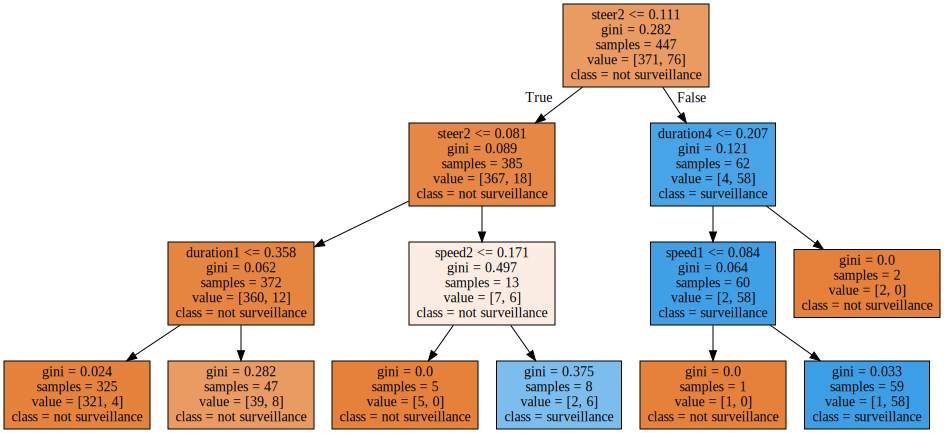

In [45]:
from sklearn import tree
import graphviz

label_names = ['not surveillance', 'surveillance']
feature_names = X.columns

dot_data = tree.export_graphviz(model,
                    feature_names=feature_names,  
                    filled=True,
                    class_names=label_names)  
graph = graphviz.Source(dot_data)  
graph

# One more classifier: Random forest

## Build and train your classifier

We can build a random forest classifier like this:

```python
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
```

But you're in charge of fitting it to your training data!

* **Tip:** You can also set `max_depth` here, but you won't be able to visualize the result.
* **Tip:** Increase `n_estimators` to 100 to make a better classifier.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest_model=RandomForestClassifier(n_estimators=100, max_depth=5)
results=forest_model.fit(X_train, y_train)

## What are the important features?

In [48]:
pd.DataFrame({
"name": X_train.columns,
"pct_contribution": results.feature_importances_
}).sort_values(by="pct_contribution", ascending=False)

,name,pct_contribution
21,steer2,0.204562
20,steer1,0.173809
24,steer5,0.077085
29,squawk_1,0.072564
17,altitude3,0.053257
25,steer6,0.040064
15,altitude1,0.038501
23,steer4,0.033755
10,speed1,0.029258
9,boxes5,0.021423


In [49]:
predictions=forest_model.predict(X_test)
matrix=confusion_matrix(y_test, predictions)
matrix=pd.DataFrame(matrix, index=["Actual_0","Actual_1"], columns=["Predicted_0","Predicted_1"])

total=127+2+5+16

#Accuracy
print(f"The accuracy is {(127+16)/total*100:.2f}%.")

#Error rate
print(f"The error pct is {(2+5)/total*100:.2f}%.")

#Specificity (errors)
print(f"The specificity pct is {127/(127+2)*100: .2f}%.")

#Sensitivity/recall (correct predictions)
print(f"The sensitivity/recall pct is {16/(16+5)*100: .2f}%.")

print("---------------------------------------")

print(matrix)

The accuracy is 95.33%.
The error pct is 4.67%.
The specificity pct is  98.45%.
The sensitivity/recall pct is  76.19%.
---------------------------------------
          Predicted_0  Predicted_1
Actual_0          127            2
Actual_1            5           16


### Understanding the output

What is a random forest, and **why is the feature importance difference than for the decision tree?** Isn't a random forest just like a decision tree or something?

In [50]:
# A random forest is a collection of decision trees. The feature importance is different because with a random forest, 
## the features are identified by aggregating the outputs of individual trees whereas in a decision tree model, we are relying
## on the estimate of one tree.

# Random forests tend to be more accurate, particularly for large datasets, a sit is based on the theory of central tendency, i.e.,
## the larger the sample, the more accurate the estimate is to the true value. 

## How well does it perform?

In [51]:
## The random forest has an accuracy of 95.33%, ~5% higher than the accuracy of the decision tree (~90.67%). 
## The forest performs better than the tree on measures of specificity and sensitivity, and is therefore, the better model 
## amongst the three models.


### How confident do you feel in the model?

In [52]:
# Same as above

# Actually finding spy planes

Now let's try ot actually find our spy planes

## Retrain our model

When we did test/train split, we trained our model with only a subset of our data, so we could test with the rest. Now that we're working in the "real world" we want to re-train it using not just `_train` and `_test` data, but instead **everything we have labels for.**

## Filter for planes we want to predict

We have a dataframe of features that includes three types of planes:

* Those that are labeled as surveillance planes
* Those that are labeled as not surveillance
* Those that aren't labeled

Which do we want to predictions for? **Filter a new dataframe that's just those.**

* **Tip:** Scroll up to see where you created your `train_df`, it's the opposite!

In [53]:
df_no_labels=df[df["label"].isna()]

How many planes do you have in that list? **Confirm it's about 19,200.**

In [54]:
df_no_labels.shape
# Yes

(19202, 35)

## Predicting 

Build your `X` - remember you need to drop a few columns - and use that to make a prediction for each plane.

**Assign the prediction into the `predicted` column**.

* **Tip:** Scroll up to see where you created your features for training, it's similar
* **Tip:** pandas will yell at us about setting values on copies of a slice but it's fine

In [55]:
df_no_labels.columns

Index(['adshex', 'duration1', 'duration2', 'duration3', 'duration4',
       'duration5', 'boxes1', 'boxes2', 'boxes3', 'boxes4', 'boxes5', 'speed1',
       'speed2', 'speed3', 'speed4', 'speed5', 'altitude1', 'altitude2',
       'altitude3', 'altitude4', 'altitude5', 'steer1', 'steer2', 'steer3',
       'steer4', 'steer5', 'steer6', 'steer7', 'steer8', 'flights', 'squawk_1',
       'observations', 'type', 'label', 'type_code'],
      dtype='object')

In [56]:
X=df_no_labels.drop(columns=["label","adshex","type"])

## How many planes did it predict to be surveillance planes?

It should be roughly around 70-80 planes.

In [57]:
predictions=forest_model.predict(X)

predictions=pd.DataFrame(predictions, columns=["prediction"])

predictions["prediction"].value_counts()

# Ans: 81 planes

0.0    19093
1.0      109
Name: prediction, dtype: int64

## But.. what about those other ones? The ones that are just below the threshold?

The cutoff for a prediction of `1` is 50%, but since we have a lot of time we're interested in investigating the top 150. To get the probability for each row, you will use `clf.predict_proba` instead of `clf.predict`. Also, to get the predicted probability for the `1` category, you'll need to add `[:,1]` to the end of the

```python
clf.predict_proba(***your features***)[:,1]
```

**Create a new column called `predicted_prob` that is the chance that the plane is a surveillance plane.**

* **Tip:** You dropped three columns when using `clf.predict`, but if you drop the same three you'll get an error now. There's now an extra column that you'll need to drop! What is it?

In [58]:
probabilities=forest_model.predict_proba(X)

probabilities=pd.DataFrame(probabilities).add_prefix("proba")

results_df=probabilities.join(predictions).join(df_no_labels)

results_df

,proba0,proba1,prediction,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label,type_code
0,0.996942,0.003058,0.0,A,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158.0,0.0,11776.0,GRND,NaN,248.0
1,0.961915,0.038085,0.0,A00000,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392.0,0.0,52465.0,TBM7,NaN,431.0
2,0.994882,0.005118,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.997511,0.002489,0.0,A00008,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24.0,0.0,2176.0,PA46,NaN,350.0
4,0.948323,0.051677,0.0,A0001E,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10.0,1135.0,630.0,C56X,NaN,126.0
5,0.996400,0.003600,0.0,A0002B,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6.0,2356.0,632.0,C82S,NaN,133.0
6,0.980327,0.019673,0.0,A00049,0.186441,0.118644,0.288136,0.169492,0.237288,0.152542,0.067797,0.101695,0.338983,0.338983,0.037181,0.037535,0.120751,0.164306,0.640227,0.032224,0.025850,0.072238,0.172805,0.696884,0.031870,0.042139,0.188385,0.452904,0.089589,0.153683,0.007790,0.014518,59.0,0.0,2824.0,PC12,NaN,356.0
7,0.865207,0.134793,0.0,A00063,0.214286,0.142857,0.285714,0.285714,0.071429,0.250000,0.500000,0.142857,0.107143,0.000000,0.157757,0.830074,0.011951,0.000217,0.000000,0.999783,0.000217,0.000000,0.000000,0.000000,0.030204,0.047805,0.344415,0.191439,0.130378,0.212516,0.014993,0.008040,28.0,0.0,4602.0,R66,NaN,369.0
8,0.996362,0.003638,0.0,A00076,0.333333,0.266667,0.222222,0.155556,0.022222,0.466667,0.222222,0.088889,0.200000,0.022222,0.232426,0.204649,0.316893,0.229025,0.017007,0.032313,0.028912,0.454649,0.436508,0.047619,0.043651,0.031179,0.129252,0.586735,0.049887,0.098639,0.009070,0.018707,45.0,0.0,1764.0,DA42,NaN,164.0
9,0.990803,0.009197,0.0,A0007A,0.103448,0.396552,0.275862,0.103448,0.120690,0.086207,0.396552,0.362069,0.000000,0.155172,0.021350,0.079775,0.285263,0.609912,0.003700,0.253661,0.244258,0.128950,0.373131,0.000000,0.006089,0.011022,0.224757,0.496994,0.139664,0.106367,0.003931,0.003006,58.0,1200.0,12974.0,BE36,NaN,54.0


### Get the top 200 predictions

Take a look at what the probabilities look like, showing the top 200 planes that are **most likely to be surveillance planes.**

Then save them to a file for later research.

In [59]:
top_200=results_df.sort_values(by="proba1", ascending=False).head(200)

In [60]:
top_200

,proba0,proba1,prediction,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,label,type_code
11678,0.058043,0.941957,1.0,A7941A,0.303030,0.212121,0.121212,0.181818,0.181818,0.272727,0.151515,0.212121,0.212121,0.151515,0.046512,0.139535,0.303779,0.395349,0.114826,0.084302,0.072674,0.122093,0.319767,0.401163,0.026163,0.023256,0.142442,0.505814,0.090116,0.122093,0.013081,0.027616,33.0,0.0,688.0,C208,NaN,97.0
7869,0.082011,0.917989,1.0,A4E1B2,0.076923,0.153846,0.076923,0.153846,0.538462,0.076923,0.153846,0.230769,0.307692,0.230769,0.763190,0.106748,0.112883,0.008589,0.008589,0.002454,0.089571,0.274847,0.633129,0.000000,0.020859,0.023313,0.213497,0.476074,0.110429,0.123926,0.004908,0.008589,13.0,0.0,815.0,P28A,NaN,323.0
3019,0.113492,0.886508,1.0,A1A952,0.071429,0.357143,0.214286,0.142857,0.214286,0.142857,0.285714,0.285714,0.142857,0.142857,0.052734,0.304688,0.572266,0.039062,0.031250,0.019531,0.079102,0.121094,0.559570,0.220703,0.016602,0.030273,0.207031,0.487305,0.085938,0.145508,0.011719,0.007812,14.0,4573.0,1024.0,T206,NaN,417.0
9612,0.137920,0.862080,1.0,A60EC5,0.235294,0.058824,0.000000,0.235294,0.470588,0.117647,0.117647,0.058824,0.000000,0.705882,0.040573,0.050119,0.199682,0.247414,0.462212,0.018298,0.027844,0.024662,0.107399,0.821798,0.021480,0.054097,0.271281,0.307080,0.105012,0.210024,0.009547,0.008751,17.0,2405.0,1257.0,PC12,NaN,356.0
7139,0.139302,0.860698,1.0,A46285,0.142857,0.214286,0.071429,0.142857,0.428571,0.142857,0.142857,0.357143,0.000000,0.357143,0.034988,0.089115,0.229665,0.426734,0.219498,0.056519,0.055622,0.046950,0.365132,0.475778,0.026316,0.054426,0.294856,0.293660,0.162081,0.138756,0.010167,0.004785,14.0,1200.0,3344.0,B58T,NaN,44.0
2123,0.150514,0.849486,1.0,A12389,0.083333,0.125000,0.250000,0.208333,0.333333,0.125000,0.083333,0.750000,0.041667,0.000000,0.296853,0.680388,0.022759,0.000000,0.000000,0.337033,0.516016,0.101292,0.045659,0.000000,0.007727,0.016297,0.302051,0.346446,0.153976,0.147232,0.006041,0.005198,24.0,1200.0,7118.0,C172,NaN,88.0
17621,0.156262,0.843738,1.0,AC5302,0.018868,0.132075,0.150943,0.301887,0.396226,0.018868,0.169811,0.528302,0.169811,0.113208,0.120769,0.203584,0.448595,0.226932,0.000120,0.349258,0.439017,0.207256,0.004470,0.000000,0.006825,0.028776,0.277219,0.370330,0.136814,0.158325,0.004989,0.002794,53.0,1200.0,25056.0,PA24,NaN,342.0
2171,0.168020,0.831980,1.0,A12CDF,0.083333,0.083333,0.333333,0.250000,0.250000,0.083333,0.250000,0.333333,0.333333,0.000000,0.129649,0.342886,0.527465,0.000000,0.000000,0.604572,0.097578,0.258274,0.039577,0.000000,0.017059,0.019106,0.284886,0.297168,0.141931,0.196520,0.016377,0.016035,12.0,1200.0,2931.0,C180,NaN,90.0
16278,0.169505,0.830495,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13836,0.172537,0.827463,1.0,A954AD,0.000000,0.038462,0.038462,0.115385,0.807692,0.000000,0.038462,0.076923,0.038462,0.846154,0.032160,0.039294,0.123845,0.179043,0.625658,0.144778,0.123845,0.127587,0.116595,0.487194,0.006081,0.019179,0.292480,0.346392,0.169103,0.150743,0.005263,0.005029,26.0,1144.0,8551.0,TBM7,NaN,431.0


# Questions

### Question 1

What kind of machine learning are we doing here, and why are we doing it?

In [61]:
# In this exercise, we trained and tested machine learning models to detect patterns in data and classify data based on 
## these patterns.

### Question 2

What are a few different ways you can deal with categorical data? Think about how we dealt with race in the reveal regression compared to how we dealt with type in this dataset.

In [62]:
# In the mortage analysis exercise, we used categorical data to predict bias. Here, we used categorical data to classify planes.

### Question 3

Every time we ran a machine learning algorithm on our dataset, we looked at feature importance.

* When might it be important to explain what our model found important?
* When might it not be important?

In [63]:
# Whichever classification model we choose, it is important to look at the factors/features based on which the model made 
## predictions.

# The interpretation of features is different for logistic regression and trees/forests. In a  logistic regression, 
## I would compare the odds-ratios of my independent variables to see which ones are the strongest predictors.
## The control variables are not as important, but it might be useful to check the effects they have, so we can re-think
## including/excluding them.

# In a decision tree, the features are important in understanding the patterns that the algorithm found, but the numbers
## don't mean much as they are only telling us which features consitute the largest share in the tree. They are key features
## but it does not mean that they have a correlation with the outcome variable. 


### Question 4

Using words and not column names, describe what the machine learning algorithm found to be important when identifying surveillance planes.

In [64]:
# The decision tree and forest plots found the steer of the aircraft to be the strongest predictor of whether it was a 
## surveillance plane or not.

### Question 5

Why did we use test/train split when it would have been more effective to give our model all of the data from the start?

In [65]:
# To avoid over-fitting 

### Question 6

Why did we use a random forest instead of a decision tree or logistic regression? Was there something about the data?

In [66]:
# To get a better accuracy rate

### Question 7

Why did we use probability instead of just looking for planes with a predicted value of 1? It seems like we should have just trusted the algorithm, right?

In [67]:
# To potentially determine our own cut-off instead of using the >0.5 cut off that the algorithm uses.

### Question 8

What if our random forest or input dataset were flawed? What would be the repercussions?

In [68]:
# Major - as the story makes important allegations against the government

### Question 9

The government could claim that we're threatening national security by publishing this paper as well as publishing this code - now anyone could look for planes that are surveilling them. What do you think?

In [69]:
# Yes, that is absolutely true. The story will have to be reviewed by experts on aircrafts, and the air force. The consequences
## will have to be considered. 

### Question 10

We're using data from the past, but you can get real-time flight data from many services. Can you think of any uses for this algorithm using real-time instead of historical data?

In [70]:
# Real-time data can give us an imteractive story wherein readers can find out potential surveillance planes real-time. 
## However, I would refrain from doing so, as the risks are much higher. With historical data, one is only providing 
## information about surveillance planes, but by providing easy access to real time data, the story urges readers to take action.

### Question 11

This isn't a question, but if you look at `candidates.csv` and `candidates-annotates.csv` you can see how Buzzfeed did their research after finding a list of suspicious planes.

In [71]:
# Thank you!

#### The End!